# 14.9 用于预训练BERT的数据集
- **目录**
  - 14.9.1 为预训练任务定义辅助函数
    - 14.9.1.1 生成下一句预测任务的数据
    - 14.9.1.2 生成遮蔽语言模型任务的数据
  - 14.9.2 将文本转换为预训练数据集

为了预训练 14.8节中实现的BERT模型，我们需要以理想的格式生成数据集，以便于**两个预训练任务：遮蔽语言模型和下一句预测。** 一方面，最初的BERT模型是在两个庞大的图书语料库和英语维基百科（参见 14.8.5节）的合集上预训练的，但它很难吸引这本书的大多数读者。另一方面，现成的预训练BERT模型可能不适合医学等特定领域的应用。因此，在定制的数据集上对BERT进行预训练变得越来越流行。为了方便BERT预训练的演示，我们使用了较小的语料库WikiText-2。
与 14.3节中用于预训练word2vec的PTB数据集相比，WikiText-2（1）保留了原来的标点符号，适合于下一句预测；（2）保留了原来的大小写和数字；（3）大了一倍以上。
- **要点：**
  - **BERT的预训练任务**：
    - BERT模型的预训练涉及两个主要任务：遮蔽语言模型和下一句预测。
  - **原始的BERT预训练数据集**：
    - 最初的BERT模型是在两个大型数据集：图书语料库和英语维基百科的合集上预训练的。
  - **现成的BERT与定制领域的差异**：
    - 虽然可以获得现成的预训练BERT模型，但这些模型可能不适合特定的应用领域，如医学。因此，在特定的数据集上自行预训练BERT变得越来越受欢迎。
  - **WikiText-2数据集**：
    - 为了演示BERT的预训练，文中使用了WikiText-2这一较小的语料库。
    - 与PTB数据集相比，WikiText-2有以下特点：
      - 保留了原始的标点符号，使其适用于下一句预测任务。
      - 保留了原始的大小写和数字。
      -  它的大小是PTB数据集的两倍多。

In [3]:
%matplotlib inline
import os
import random
import torch
from d2l import torch as d2l

- 在WikiText-2数据集中，每行代表一个段落，其中在任意标点符号及其前面的词元之间插入空格。
- 保留至少有两句话的段落。为了简单起见，我们仅使用句号作为分隔符来拆分句子。
- 我们将更复杂的句子拆分技术的讨论留在本节末尾的练习中。


In [7]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
'''
提取段落，paragraphs：二维数组，每个元素是由多个句子构成的的一维数组（段落）,
段落中的句子个数不等（1-35）。
'''
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    ## 使用句号.来拆分句子
    ## 注意即使某个line里只有一个句子，其分割长度也至少等于2
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    
    '''
    paragraphs是一个二维list，保存每个段落，每个段落又是一个一维list，保存该段落的所有句子。
    句子个数从1-35不等。
    shuffle打乱的是段落顺序，而不是每个段落的句子顺序。
    '''
    random.shuffle(paragraphs)
    return paragraphs

-------------
- **说明：_read_wiki函数解读**

In [11]:
## _read_wiki函数测试

path = r'..\data\wikitext-2'
ps = _read_wiki(path)
l=[]
for p in ps:
    l.append(len(p))
min(l),max(l),ps[0]

(1,
 35,
 ['on returning to london , wheeler moved into a top @-@ floor flat near gordon square with his wife and child',
  'he returned to working for the royal commission , examining and <unk> the historic structures of essex',
  "in doing so , he produced his first publication , an academic paper on colchester 's roman <unk> gate which was published in the transactions of the essex archaeological society in 1920",
  "he soon followed this with two papers in the journal of roman studies ; the first offered a wider analysis of roman colchester , while the latter outlined his discovery of the vaulting for the city 's temple of claudius which was destroyed by <unk> 's revolt",
  'in doing so , he developed a reputation as a roman archaeologist in britain',
  'he then submitted his research on romano @-@ rhenish pots to the university of london , on the basis of which he was awarded his doctorate of letters ; <unk> until his knighthood he styled himself as dr wheeler',
  'he was unsatisf

In [12]:
## 后文中应用到词元化中的代码，目的是取出所有句子，让在一个一维列表里
#[sentence for p in ps for sentence in p]

In [13]:
'''
两次迭代能够将二维数组迭代取出所有元素放在一个数组里。
先外层迭代，然后再内层迭代。
j in l外层迭代，i in j 内层迭代。
'''
l=[[1,2,3],[5,6,7]]
[i for j in l for i in j]

[1, 2, 3, 5, 6, 7]

In [14]:
## 与前例效果一致，先外层迭代，后内层迭代
h=[]
for j in l:
    for i in j:
        h.append(i)
h

[1, 2, 3, 5, 6, 7]

In [15]:
import numpy as np
l1=np.array(l)
np.where(l1==1)
len(ps[30][0].split('.')),ps[30],ps[30][0].split('.')

(1,
 ['nss derived most of its revenue from the operation of restaurants at railway stations ; in 1939 , this amounted to 80 %',
  'initially , the company operated the restaurant at oslo ø ; from 1921 , it also took over operation of the restaurants at oslo west station , hamar , <unk> , <unk> and <unk>',
  'the following year , four more restaurants were added : <unk> , <unk> , <unk> and hell',
  'nss also established its first kiosk , at bergen station',
  'in 1923 , the company was allowed to take over all restaurants in the railway districts of oslo and hamar ; by 1925 , it had taken over operation of the restaurants at lillehammer , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , trondheim , <unk> , <unk> , <unk> , <unk> and <unk> .'],
 ['nss derived most of its revenue from the operation of restaurants at railway stations ; in 1939 , this amounted to 80 %'])

In [16]:
## 类似‘hello,’这样字符串分割后的长度的确等于2，为何有这种表现？
len('hello,'.split(','))

2

In [17]:
len(','.split(',')), ','.split(',')## 即便两边为空，分割后的长度也是2，很诡异吧

(2, ['', ''])

------------

## 14.9.1 为预训练任务定义辅助函数

在下文中，我们首先为BERT的两个预训练任务实现辅助函数。这些辅助函数将在稍后将原始文本语料库转换为理想格式的数据集时调用，以预训练BERT。

### 14.9.1.1 生成下一句预测任务的数据
根据 14.8.5.2节的描述，`_get_next_sentence`函数生成二分类任务的训练样本。

In [18]:
#@save
'''
传入的数据是真实的句子与下一句以及段落。
按照0.5的概率设置is_next为False，随机从语料中抽取一句作为下一句。

如果按照0.5的概率，is_next没有设置为False，将is_next设为True，
同时将原数据返回，也就是真实的前后句子对。

其目的就是按照50%的概率将真实的前后句子对修改成下一句为随机抽取的句子，并将is_next设为False。
'''
def _get_next_sentence(sentence, next_sentence, paragraphs):
    ## is_next有50%的可能性被设置为True
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套(段落，句子，词元)
        '''
        随机挑选一个句子,用于“下一句”预测训练。
        里层的random.choice随机挑选段落，外层的random.choice在该段落中随机挑选句子。
        '''
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

-------------
- **说明：随机性测试**

In [19]:
import numpy as np
r=[]
for _ in range(10000):
    r.append(random.random())
len(np.array(r)[(np.array(r)<0.5)])/10000

0.5049

In [20]:
## random.choice的用法
s=(np.arange(120)).reshape(4,5,6)
s

array([[[  0,   1,   2,   3,   4,   5],
        [  6,   7,   8,   9,  10,  11],
        [ 12,  13,  14,  15,  16,  17],
        [ 18,  19,  20,  21,  22,  23],
        [ 24,  25,  26,  27,  28,  29]],

       [[ 30,  31,  32,  33,  34,  35],
        [ 36,  37,  38,  39,  40,  41],
        [ 42,  43,  44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53],
        [ 54,  55,  56,  57,  58,  59]],

       [[ 60,  61,  62,  63,  64,  65],
        [ 66,  67,  68,  69,  70,  71],
        [ 72,  73,  74,  75,  76,  77],
        [ 78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89]],

       [[ 90,  91,  92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101],
        [102, 103, 104, 105, 106, 107],
        [108, 109, 110, 111, 112, 113],
        [114, 115, 116, 117, 118, 119]]])

In [21]:
'''
choice函数依次在0,1,2轴上随机选择一个元素.
下面三个例子依次为：
（1）随机选择0轴数据，即选择一个矩阵；
（2）在0轴上随机选择一个矩阵之后，在该矩阵上随机选择一行；
（3）在0轴上随机选择一个矩阵之后，在1轴上随机选择一行之后，在该行随机选择一个元素。
'''
random.choice(list(s)), random.choice(random.choice(list(s))), \
random.choice(random.choice(random.choice(list(s))))

(array([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29]]),
 array([ 96,  97,  98,  99, 100, 101]),
 1)

In [22]:
### paragraphs测试
file_name = r'e:\deepdata\parag.txt'
paragraphs=[]
with open(file_name, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    # 大写字母转换为小写字母
    ## 使用句号.来拆分句子
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line)>0 and line!= '']
    random.shuffle(paragraphs)
    ## 返回的是打乱顺序的句子list，应该是主要用于MLM的训练

In [23]:
## 这个的确是获取句子
random.choice(random.choice(paragraphs))

''

In [24]:
## 这个也是获取一个句子，但是返回数据是list类型
random.choice(paragraphs)

['odd andersen/afp via getty images']

-------------

- 下面的函数通过调用`_get_next_sentence`函数从输入`paragraph`生成用于下一句预测的训练样本。
  - **这里`paragraph`是句子列表，其中每个句子都是词元列表。** 
- 自变量`max_len`指定预训练期间的BERT输入序列的最大长度。


In [25]:
#@save
'''
下一句预测函数_get_nsp_data_from_paragraph的3个返回值组成元组，
然后再将多个元组保存在list：
tokens: ['<cls>','abc','def','<sep>','hij','klm','<sep>']构成；
segments: [0,0,0,0,1,1,1]
is_next: True或者False

3个元素组成元组，然后多个元组存放在list里。
[(t,s,i),(t,s,i),...]
'''
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    ## 将段落依次迭代到最后一句之前，不包括最后一句
    ## 因为最后一句没有下一句了，无法预测
    for i in range(len(paragraph) - 1):
        ## 生成句子与下一句对，注意有50%句子对的下一句不是真实的下一句
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 考虑1个'<cls>'词元和2个'<sep>'词元
        '''
        限定句子对的长度不超过max_len，如超过则忽略。
        如果max_len设置过小，将忽略很多句子。
        '''
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        '''
        将句子转换成词元列表和片段。
        注意tokens由['<cls>','abc','def','<sep>','hij','klm','<sep>']构成；
        而segments则是[0,0,0,0,1,1,1]这种形式构成。0表示第一个句子，1表示下一句。
        '''       
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        
        ## 返回词元列表和片段以及是否为真实下一句，放在一个元组里，再保存在list里
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

### 14.9.1.2 生成遮蔽语言模型任务的数据

- 为了从BERT输入序列生成遮蔽语言模型的训练样本，我们定义了以下`_replace_mlm_tokens`函数。
  - 在其输入中，`tokens`是表示BERT输入序列的词元的列表，
  - `candidate_pred_positions`是不包括特殊词元的BERT输入序列的词元索引的列表（特殊词元在遮蔽语言模型任务中不被预测），
  - 以及`num_mlm_preds`指示预测的数量（选择15%要预测的随机词元）。
- 在 14.8.5.1节中定义遮蔽语言模型任务之后，在每个预测位置，输入可以由特殊的“掩码”词元或随机词元替换，或者保持不变。
- 最后，该函数返回可能替换后的输入词元、发生预测的词元索引和这些预测的标签。


In [26]:
#@save
'''
用于MLM而不是下一句预测。
tokens是前面获取的带有<cls><sep>的输入序列表示。

andidate_pred_positions则是不包含<cls><sep>特殊词元的索引列表，
即除了特殊词元外的有效词元在tokens序列中的索引。
'''
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    mlm_input_tokens = [token for token in tokens]
    
    ## 保存被掩码（预测）的词元索引及其标签（即原词元）
    pred_positions_and_labels = []
    
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    ## 用于随机获取被掩码的词元
    random.shuffle(candidate_pred_positions)
    ## 然后随机挑选一个词元(在tokens序列中的索引)进行操作：屏蔽、保持不变或词表中的随机词元代替
    ## 随机挑选是通过上一行的shuffle函数实现的
    ## mlm_pred_position是被挑选的需要被掩码的词元在原词元列表中的索引
    for mlm_pred_position in candidate_pred_positions:
        ## 用于控制掩码词元的个数，通过标签来控制，
        ## 等于设定的个数(即num_mlm_preds)时退出迭代
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80%概率将预测词元替换为“<mask>”
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的概率保持词不变
            if random.random() < 0.5:
                '''
                candidate_pred_positions就是用来保存词元在原tokens序列中的位置索引，
                只不过在前面进行shuffle，然后由mlm_pred_position迭代。
                获取原词元保存到masked_token里，达到保持不变的效果。
                总体概率是:10%=（1-80%）*50%。
                '''
                masked_token = tokens[mlm_pred_position]            
            else:
                # 10%的时间：用随机词替换该词
                ## 随机词取自词表，通过random.choice获取
                masked_token = random.choice(vocab.idx_to_token)
                
        ## 设置被掩码词元的值：80%是<masked>，10%是原词元，10%是词表中的随机词元
        mlm_input_tokens[mlm_pred_position] = masked_token
        
        ## 被掩码的词元在原词元序列中的索引位置和原词元，二者保存在一个元组中
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    '''
    进行了掩码操作后的词元序列和标签（保存索引位置与原词元）
    '''
    return mlm_input_tokens, pred_positions_and_labels

In [27]:
## inplace打乱顺序
sf=[1,2,3,4,5,6]
random.shuffle(sf)
sf

[2, 3, 4, 1, 6, 5]

通过调用前述的`_replace_mlm_tokens`函数，以下函数将BERT输入序列（`tokens`）作为输入，并返回输入词元的索引（在 14.8.5.1节中描述的可能的词元替换之后）、发生预测的词元索引以及这些预测的标签索引。


In [28]:
#@save
'''
使用_replace_mlm_tokens来生成MLM序列以及预测标签（被掩码词元在词表中的索引）。
'''
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # tokens是一个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        ## 略过特殊词元。
        if token in ['<cls>', '<sep>']:
            continue
        ''' 
        tokens中的非特殊词元都放在candidate_pred_positions里，
        作为候选的预测词元。也就是说tokens中除了特殊词元以外的其他词元,
        都有可能作为预测词元被掩码（当然这里的掩码有3种操作选择）。
        
        candidate_pred_positions保存的是词元在序列中的索引位置。
        '''
        candidate_pred_positions.append(i)
        
    # 遮蔽语言模型任务中预测15%的随机词元
    '''
    在这儿设置概率，15%的词元设为掩码预测词元
    num_mlm_preds是一个整数，>=1,<=序列长度*0.15(取整)。
    '''
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    
    '''
    调用前面定义的函数生成掩码（预测）词元，以及预测词元标签。
    tokens是词元列表，包含特殊词元；
    candidate_pred_positions：非特殊词元的在原序列中的索引列表；
    num_mlm_preds：15%被掩码（预测）的词元个数。
    '''
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    
    ## 按照词元索引排序
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    
    ## pred_positions是索引位置，mlm_pred_labels是标签（原词元）
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    
    ## 前面都是按照词元字符串进行操作，最后本函数返回之前转换成词表索引
    ## 返回掩码输入词元序列词表索引，掩码（预测）词元在原序列中的索引位置，
    ## 预测标签（原词元）的词表索引
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## 14.9.2 将文本转换为预训练数据集

- 现在我们几乎准备好为BERT预训练定制一个`Dataset`类。
- 此之前，我们仍然需要定义辅助函数`_pad_bert_inputs`来将特殊的“&lt;mask&gt;”词元附加到输入。
- 它的参数`examples`包含来自两个预训练任务的辅助函数`_get_nsp_data_from_paragraph`和`_get_mlm_data_from_tokens`的输出。


In [29]:
#@save
'''

'''
def _pad_bert_inputs(examples, max_len, vocab):
    ## 最大掩码长度，填充后序列的15%，并非真实序列的有效长度
    max_num_mlm_preds = round(max_len * 0.15)
    
    '''
    all_token_ids:所有词元（也就是一个序列的词元加上特殊词元，再加上填充）的ID（词表id）,
    all_segments:所有片段(有0,1构成)，
    valid_lens:有效长度，不包含填充的序列长度（词元个数）。
    '''
    all_token_ids, all_segments, valid_lens,  = [], [], []
    ## “all:所有”的意思就是某个序列的词元、特殊词元、填充三个一起。
    ##所有预测位置，所有MLM权重，所有MLM标签
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    ## 下一句预测标签
    nsp_labels = []
    ## 要看看examples的结构
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        
        ## 填充到最大长度，不够的地方使用<pad>填充。最后序列的长度都是一样的
        ## 即max_len。注意是使用<pad>的词表索引(id)填充的
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        
        ## 片段是填充‘0’，[0,0,0,...,1,1,...,0,0,0,...]，
        ## 最后一个1后面的0是填充的
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        
        ## 预测词元索引位置也是填充0
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        ##  + [0.0] 后面是填充词元<pad>的初始权重0，这样相乘就会忽略它们的权重计算
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        ## <pad>的标签也设为0
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        
        ## nsp_labels保存是否为下一句，将True,False转换为0,1表示
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
        
    ## 函数的功能就是各种个填充，直到填满到max_len长度
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

- 将用于生成**两个预训练任务的训练样本的辅助函数和用于填充输入的辅助函数放在一起**，我们定义以下`_WikiTextDataset`类为用于预训练BERT的WikiText-2数据集。
- 通过实现`__getitem__ `函数，我们可以任意访问WikiText-2语料库的一对句子生成的预训练样本（遮蔽语言模型和下一句预测）样本。
- 最初的BERT模型使用词表大小为30000的WordPiece嵌入。
  - WordPiece的词元化方法是对 14.6.2节中原有的字节对编码算法稍作修改。
- 为简单起见，我们使用d2l.tokenize函数进行词元化。
  - 出现次数少于5次的不频繁词元将被过滤掉。


In [30]:
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        
        '''
        句子已经词元化了。
        应该是如此形式：[[['aa','bb','cc','dd'],['ee','ff','gg','hh'], ...]]。
        不再是一个完成句子形式。
        '''
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        
        ## 将所有句子全部迭代取出保存在一个list里，结果是一个一维数组
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            ## 注意区分list的extend与append函数的区别
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        ## 很明显此处是使用有效长度(真实长度)来计算掩码（预测）词元的个数。
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        
        # 填充输入，填充到固定长度max_len，以便于计算和处理
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

-------------
- **说明：_WikiTextDataset类解析**


In [34]:
'''
对语料词元化，运行速度有点慢,内容太长不完全显示.
结果是三维数组。段落-句子-词元
'''
path = r'..\data\wikitext-2'
ps = _read_wiki(path)
paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in ps]
#paragraphs

#### 运行结果
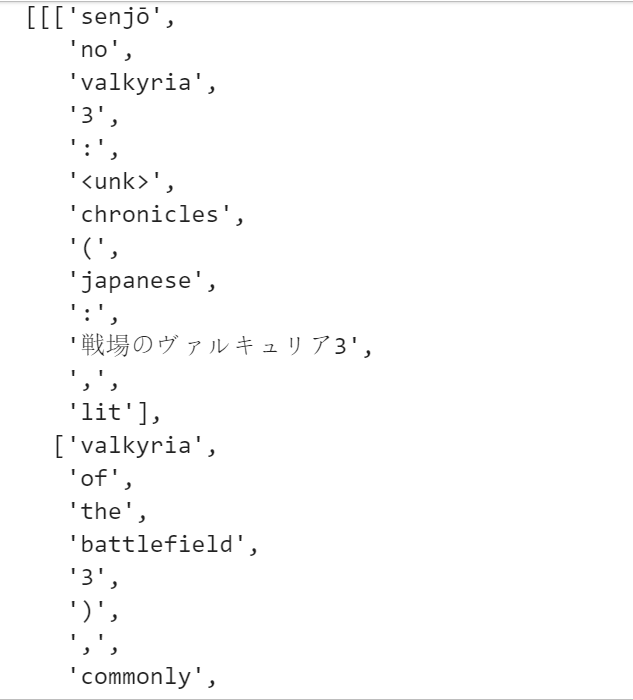

In [27]:
## 段落个数，第一个段落的句子个数，第一个句子的词元个数
len(paragraphs),len(paragraphs[0]),len(paragraphs[0][0])

(15496, 5, 20)

In [28]:
'''
sentences是一个二维数组。
保存了74631个句子，每个句子是由词元list构成。
迭代了两层。
'''
sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
##句子个数
len(sentences)#,sentences

74631

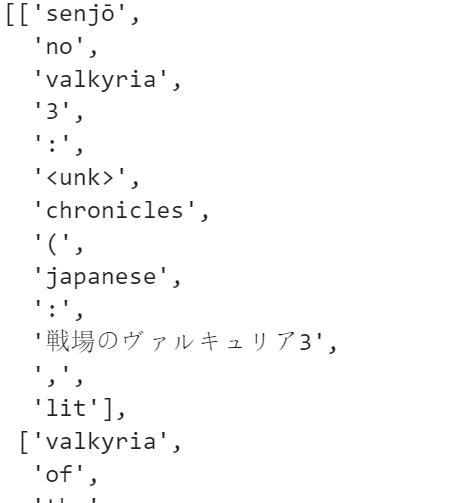

In [29]:
## list的append与extend函数的区别院系
l = [1,2,3]
l1 = ('a','b','c')
##元素添加到list
l.extend(l1)
print(l)
## 整体对象添加到list
l.append(l1)
print(l)

[1, 2, 3, 'a', 'b', 'c']
[1, 2, 3, 'a', 'b', 'c', ('a', 'b', 'c')]


In [35]:
## wtd的个数取决于max_len的大小，越大，wtd越多
## 在_get_nsp_data_from_paragraph函数中通过max_len限定句子对的长度了
## 如果超过长度将被忽略，因此会影响进入到数据集中的句子个数。
wtd=_WikiTextDataset(_read_wiki(path),64)

In [36]:
'''
_WikiTextDataset生成的数据依次为：
（1）all_token_ids：句子词元的词表索引，句子长度小于max_len的，则以<pad>的词表索引填充至max_len长度，即填充<pad>词元的索引1；
（2）all_segments：前面的多个0为句子（词元标签），中间多个1为下一句，最后用0填充至max_len
（3）valid_lens：句子对的有效长度，本例为53
（4）all_pred_positions：被预测或掩码的词元在all_token_ids中的索引，本例有8个掩码词元。
    掩码词元的个数，使用有效长度乘以0.15然后四舍五入。本例为53*0.15=0.75=8。后面还要填充至
    max_num_mlm_preds长度，该长度等于max_len*0.15后四舍五入，本例为10。因此后面填充了2个0
（5）all_mlm_weights: 有效掩码词元为8个，因此其初始权重为1；后面是填充的,因此其初始权重为0.0，不参与权重计算。
（6）all_mlm_labels：掩码词元在真实词元序列中的索引，后面也是填充0至max_num_mlm_preds长度。
（7）nsp_labels：是否为真实的下一句。1：真实；0：否。本例为真实下一句
'''
wtd[0:3]

([tensor([   3,  157,  116,    6,   15,    2,    2,    7,   29, 1412,    8,  287,
             6,   30,   52,   53, 3798, 2023,    4,   11, 2073,    2,  115,  445,
           750,  150, 5001,  180,    7,    2, 2136,   31,    2,    6,  849, 4936,
             4,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1]),
  tensor([    3,    47,    11,  2421,     2,     9,  2098,     6,  4761,    92,
             29,    40,  3626,     9,     0,     2,    79,  2531,  3014,    24,
              2,     2,     5,     0,     9,   189,    23,   205,  8955,  1020,
              4,     9, 17976,     6,    61,     5,     2,     2,     6,    30,
             13,    42,     7,     5, 12810,     2,  6019,    28,     2,  2061,
              7,  4321, 12013,     6,     8,  3136,    20,    48,     0,    27,
              5,  1510,     4,     1]),
  tensor([    3,     9, 17976,    

In [37]:
## 最大掩码长度，有效掩码长度
round(64*0.15), round(53*0.15)

(10, 8)

In [38]:
## 当max_len为64时，句子对的数量明显减少
len(wtd)

43613

-------

- 通过使用`_read_wiki`函数和`_WikiTextDataset`类，我们定义了下面的`load_data_wiki`来下载并生成WikiText-2数据集，并从中生成预训练样本。


In [39]:
#@save
## num_workers设为0，才跑得快
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = 0 # d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    '''
    DataLoader是一个迭代器。本例中共有86个批量。每个批量512个数据，
    但是最后一个批量一般小于512。
    数据的组织有区别，每个批量有7个元素，每个元素再按照批量大小512组织。
    比如第一个元素all_token_ids是长度为64的一维张量，一共有43609个，在DataLoader
    里会将其分割组合成86个形状为(512,64)的张量（最后一个小批量不一定有512行）。
    其他6个元素依次类推，不过形状可能存在差别。
    '''
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

- 将批量大小设置为512，将BERT输入序列的最大长度设置为64，我们打印出小批量的BERT预训练样本的形状。
- 注意，在每个BERT输入序列中，为遮蔽语言模型任务预测$10$（$64 \times 0.15$）个位置。


In [40]:
'''
结果中的形状数据其他都好理解，10是round(64*0.15)计算的结果。
生成数据保存的都是句子对，因此在预训练模型时，MLM和NSP的训练对象都是句子对。
在训练过程中，对句子对做了不同处理。
'''
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [41]:
#86个批量
len(train_iter)

86

In [42]:
## 每批量有7个张量，各自代表不同数据
len(list(iter(train_iter))[0]), list(iter(train_iter))[0]

(7,
 [tensor([[    3, 19862,  5118,  ...,     1,     1,     1],
          [    3,    42,     7,  ...,     1,     1,     1],
          [    3,    86,    36,  ...,     1,     1,     1],
          ...,
          [    3,    58,   116,  ...,     1,     1,     1],
          [    3,   364,    48,  ...,     1,     1,     1],
          [    3,    22,  2488,  ...,     1,     1,     1]]),
  tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]),
  tensor([26., 48., 53., 42., 59., 56., 45., 63., 63., 45., 64., 55., 46., 38.,
          57., 45., 46., 52., 25., 42., 60., 46., 47., 56., 52., 49., 43., 44.,
          54., 52., 42., 55., 47., 55., 22., 40., 44., 41., 49., 33., 57., 56.,
          25., 43., 64., 47., 37., 56., 46., 36., 34., 56., 54., 64., 47., 47.,
          32., 60., 63., 49., 24., 62., 55., 22., 48., 56., 61., 5

- 最后，我们来看一下词量。
  - 即使在过滤掉不频繁的词元之后，它仍然比PTB数据集的大两倍以上。


In [43]:
len(vocab)

20256

In [44]:
vocab.idx_to_token[3]

'<cls>'

In [45]:
vocab.token_to_idx['<sep>']

4

In [46]:
'''
训练集数据中都是句子对，3是<cls>的词表索引，4是<sep>词表索引。
'''
l=list(iter(train_iter))[0][0][0]
l

tensor([    3,    15,   651,    84,     6,   163,  1043,     8,  1276,     2,
            2,     5,  2768,     2,   237,     2,     0,   862,    31,     2,
           67,   747,     7,   422,  4029,     4,    43,   429,  3337,  1374,
         5452,     9,  4245,     2, 10245,     6,  5487,     8,  8587,     6,
           21,    38,  1029,    46,     9,     2,     4,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])

In [47]:
## 训练数据的句子对中的索引所对应词元序列
np.array(vocab.idx_to_token)[l]

array(['<cls>', 'on', '27', 'may', ',', '6', 'officers', 'and', '300',
       '<mask>', '<mask>', 'the', 'sarajevo', '<mask>', 'based', '<mask>',
       '<unk>', 'regiment', 'were', '<mask>', 'into', 'parts', 'of',
       'eastern', 'herzegovina', '<sep>', 'they', 'established',
       'platoon', 'strength', 'posts', 'in', 'nevesinje', '<mask>',
       'trebinje', ',', 'gacko', 'and', 'bileća', ',', 'with', 'their',
       'headquarters', 'also', 'in', '<mask>', '<sep>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>'], dtype='<U18')

## 小结

* 与PTB数据集相比，WikiText-2数据集保留了原来的标点符号、大小写和数字，并且比PTB数据集大了两倍多。
* 我们可以任意访问从WikiText-2语料库中的一对句子生成的预训练（遮蔽语言模型和下一句预测）样本。